## In this project we will forecast the temperature
Greg Hogg

In [2]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np

In [4]:
import xgboost as xgb
import prophet
from sklearn.ensemble import RandomForestClassifier 

## Getting the data

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 6s 0us/step


In [6]:
csv_path #This is the root path to our csv file if we want to run it in colabd

'C:\\Users\\Ramin\\.keras\\datasets\\jena_climate_2009_2016.csv'

In [9]:
print(tf.__version__)

2.10.0


In [7]:
df = pd.read_csv(csv_path)

In [8]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [148]:
df.shape # its a huge df so we prune it

(420551, 15)

In [149]:
df = df[5::6] # Starting from 5th row, take every sixth row until the end (6 is the stepsize), since the rows are every 10 minutes each, now we smaple the data every hour
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


In [150]:
df.index = pd.to_datetime(df['Date Time'], format ='%d.%m.%Y %H:%M:%S') # This is the format the date and time is written so we pass it to the function

We will be focusing on T (degC) column as this is an introduction to us.

<Axes: xlabel='Date Time'>

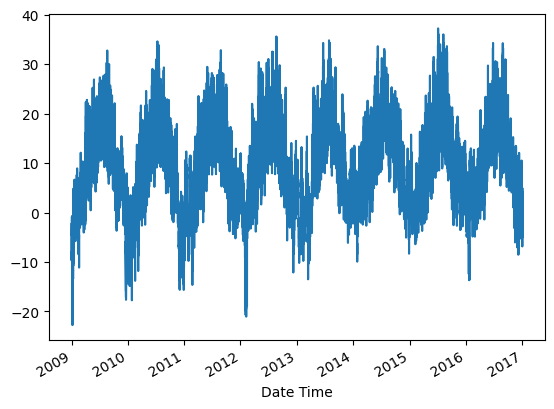

In [151]:
temp = df['T (degC)']
temp.plot()

We can see yearly temp fluctuations! Now we make a function to use the data from the previous measurements to predict the future temp.We end up with a matrix of mving window for data and predictions for every hour. So this is [X][y]

In [152]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
# So effectively we are making a 3D Tensor

In [153]:
def df_to_X_y(df, windw_size=5):
  df_as_np = df.to_numpy() #make it into numpy
  X = []
  y = []

  for i in range(len(df_as_np)-windw_size):
    row = [[a] for a in df_as_np[i:i+windw_size]] #Take 5 of the values per row. List comprehension to wrap every vaalue in a list
    X.append(row)

    label = df_as_np[i+windw_size] # this is the y value
    y.append(label)
  return np.array(X), np.array(y)

In [154]:
WINDOW_SIZE = 5
X,y = df_to_X_y(temp, WINDOW_SIZE)

In [155]:
print(X.shape) # I think this is made into 3rd for the TF model to work? 
print(y.shape)

(70086, 5, 1)
(70086,)


Splitting the data into to training and test sets. We have 70,000 rows 

In [156]:
X_train1, y_train1 = X[:60000], y[:60000]
X_val1, y_val1 = X[60000:65000],y[60000:65000] #validation
X_test1, y_test1 = X[65000:], y[65000:]

In [157]:
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

# Onto using Keras for prediction
## Iporting packages

In [158]:
from tensorflow.keras.models import Sequential #Sequential model
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint # for saving models that do best on validation
from tensorflow.keras.losses import MeanSquaredError #loass function 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam #Adam is one of several optimisers


In [159]:
model1 = Sequential() # This is the primary way we can use the Keras, API, there is a more advanced way for Clsees etc
model1.add(InputLayer((5, 1))) # This is the first layer of the NN, We given the shape, you could also use Flatten for images etc. It makes your tensor into a sequence of numbers and passes them into the layer, 
# as it is now, it is a 5 by 1, The 1 is we are predicting using only 1 variable, with a window size of 5
model1.add(LSTM(64)) #Add a 64 unit LTSM layer, its a recursive NN (So could use "SimpleRNN" or "GRU")
model1.add(Dense(8, 'relu')) #Dense here means fully connected layer, and this one has a dimention of 8 in the output space, it comes with an activation function, Where we choose it to be 'relu'
model1.add(Dense(1, 'linear')) #anther fully connected (dense layer) with linear activation with dimention 1, as this s the next value coming out

model1.summary() #have a look at the model summary after you have made it to check

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [160]:
# Setting up the checkpoint 

cp = ModelCheckpoint('model1/', save_best_only=True) # Keep the best model by lowest validation loss

model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])
# In the above, loss function is MeanSquareError, the learning rate is as defined in the machien learning, the stepas we take in gradient descent to converge on the minima, and the metrics is how we define the best model

#Fitting and Validating

In [161]:
model1.fit(X_train1, y_train1, validation_data = (X_val1, y_val1), epochs=10, callbacks=[cp])
# Epoch is just a run throug hdata, it runs as many times as specified through data each time it save the best model in the checkpit (saves or overwrites)

Epoch 1/10
1871/1875 [============================>.] - ETA: 0s - loss: 39.9896 - root_mean_squared_error: 6.3237

1875/1875 [==============================] - 18s 8ms/step - loss: 39.9103 - root_mean_squared_error: 6.3175 - val_loss: 1.1571 - val_root_mean_squared_error: 1.0757
Epoch 2/10
1868/1875 [============================>.] - ETA: 0s - loss: 1.5228 - root_mean_squared_error: 1.2340

1875/1875 [==============================] - 17s 9ms/step - loss: 1.5210 - root_mean_squared_error: 1.2333 - val_loss: 0.5938 - val_root_mean_squared_error: 0.7706
Epoch 3/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.8166 - root_mean_squared_error: 0.9036

1875/1875 [==============================] - 16s 8ms/step - loss: 0.8164 - root_mean_squared_error: 0.9036 - val_loss: 0.5364 - val_root_mean_squared_error: 0.7324
Epoch 4/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.7054 - root_mean_squared_error: 0.8399

1875/1875 [==============================] - 17s 9ms/step - loss: 0.7060 - root_mean_squared_error: 0.8403 - val_loss: 0.5095 - val_root_mean_squared_error: 0.7138
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.6719 - root_mean_squared_error: 0.8197

1875/1875 [==============================] - 15s 8ms/step - loss: 0.6718 - root_mean_squared_error: 0.8196 - val_loss: 0.5085 - val_root_mean_squared_error: 0.7131
Epoch 6/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.6599 - root_mean_squared_error: 0.8123

1875/1875 [==============================] - 15s 8ms/step - loss: 0.6599 - root_mean_squared_error: 0.8124 - val_loss: 0.4911 - val_root_mean_squared_error: 0.7008
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6527 - root_mean_squared_error: 0.8079 - val_loss: 0.4948 - val_root_mean_squared_error: 0.7034
Epoch 8/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.6483 - root_mean_squared_error: 0.8052

1875/1875 [==============================] - 15s 8ms/step - loss: 0.6477 - root_mean_squared_error: 0.8048 - val_loss: 0.4870 - val_root_mean_squared_error: 0.6979
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6444 - root_mean_squared_error: 0.8028 - val_loss: 0.4875 - val_root_mean_squared_error: 0.6982
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6422 - root_mean_squared_error: 0.8014 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012


Loading the best model into the memory 

In [162]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Lets make panda dataframes for train and test and pedictions etc.

In [163]:
train_predictions = model1.predict(X_train1)
train_predictions #just like the input but this is a prediction, to use it in pandas we have to flatten it 

1875/1875 [==============================] - 6s 3ms/step


array([[-9.875142],
       [-9.657519],
       [-8.746508],
       ...,
       [12.025058],
       [15.841477],
       [16.381481]], dtype=float32)

In [164]:
train_predictions = model1.predict(X_train1).flatten()
train_predictions

1875/1875 [==============================] - 5s 3ms/step


array([-9.875142, -9.657519, -8.746508, ..., 12.025058, 15.841477,
       16.381481], dtype=float32)

In [165]:
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': y_train1})
train_results

,Train Predictions,Actuals
0,-9.875142,-9.67
1,-9.657519,-9.17
2,-8.746508,-8.10
3,-7.230987,-7.66
4,-7.131805,-7.04
...,...,...
59995,5.953323,6.07
59996,7.133762,9.88
59997,12.025058,13.53
59998,15.841477,15.43


<Axes: >

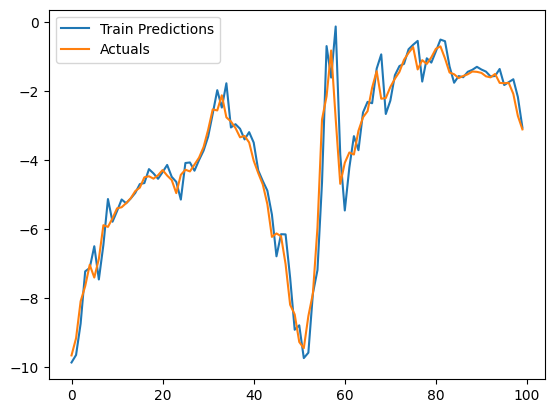

In [166]:
train_results[0:100].plot()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_results['Train Predictions'][0:100])
plt.plot(train_results['Actuals'][0:100])

How well it did on the validation data:

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

In [ ]:
plt.plot(test_results['Test Predictions'][:100]) # from zer o to 100 Hours 
plt.plot(test_results['Actuals'][:100])

# Part II

We now want to expand out model so it accepts other variables from the dataframe too. This is to leverage the change in other variables to improve the preditions (pressure, dew point, etc.) We can also use the time stamp as another variable. So we have seasonal and daily periodicity. We can also predict more than one variable. The recurrent nural netwroks are used very much for time series, but we can also use *Convolutional Nural Netwroks* too, although they are mostly used for two dimentional i.e. images, but we can also use them in one dimention and predict a a 1-D variable. CNNs can be much faster too, so its important to consider that. 

Let us automate the prediction and the actuals and the plotting in a fucntion.

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start = 0, end = 100): #plotting range but mse is over the entire set not the first 100 points
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})

  plt.plot(df['Predictions'][start:end]) # from zer0 o to 100 Hours 
  plt.plot(df['Actuals'][start:end])
  plt.xlabel('Hours')
  plt.ylabel('Tempratuce (degC)')
  plt.legend(['Predictions','Actuals'])

  return df, mse(y, predictions)


159/159 [==============================] - 0s 2ms/step


(      Predictions  Actuals
 0       14.424496    13.99
 1       13.252400    13.46
 2       12.878160    12.93
 3       12.478933    12.43
 4       12.030468    12.17
 ...           ...      ...
 5081    -1.203527    -0.98
 5082    -1.534525    -1.40
 5083    -1.716779    -2.75
 5084    -3.265001    -2.89
 5085    -3.130875    -3.93
 
 [5086 rows x 2 columns],
 0.6219079806731397)

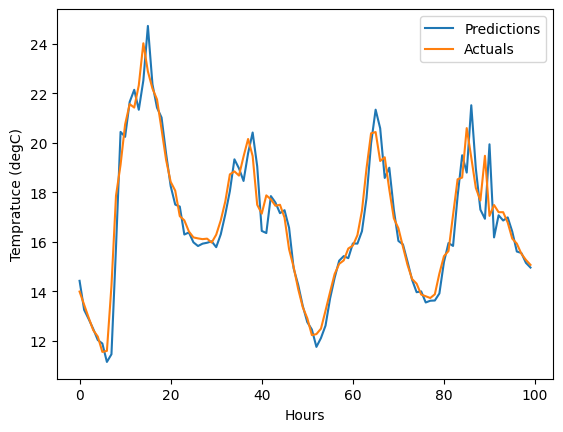

In [209]:
plot_predictions1(model1, X_test1, y_test1)

# Lets make a CNN instead of the LSTM model we used.

In [ ]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2)) #replaced te LSTM, sliding window, input window is length 5, Kernel size is the number of data points it gets to fit.
model2.add(Flatten()) # we do not want it to be two dimentional outside of the CNN
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Compare the number of parameters with the LSTM, this is much lower, makes the model run faster. 

In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

# Lets do the same thing with GRU.
The number of parameters would beween CNN and LSTM for GRU (Gated Recurrent Unit). It is a modified version of LSTM. It is also more prone to overfitting as more ocmplex models are. 

In [ ]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary() #Note the number of parameters. 

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [179]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
1866/1875 [============================>.] - ETA: 0s - loss: 37.5356 - root_mean_squared_error: 6.1266

1875/1875 [==============================] - 15s 7ms/step - loss: 37.3716 - root_mean_squared_error: 6.1132 - val_loss: 1.0750 - val_root_mean_squared_error: 1.0368
Epoch 2/10
1866/1875 [============================>.] - ETA: 0s - loss: 1.8137 - root_mean_squared_error: 1.3468

1875/1875 [==============================] - 13s 7ms/step - loss: 1.8110 - root_mean_squared_error: 1.3457 - val_loss: 0.6005 - val_root_mean_squared_error: 0.7749
Epoch 3/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.8607 - root_mean_squared_error: 0.9277

1875/1875 [==============================] - 15s 8ms/step - loss: 0.8594 - root_mean_squared_error: 0.9270 - val_loss: 0.5241 - val_root_mean_squared_error: 0.7239
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.7018 - root_mean_squared_error: 0.8378

1875/1875 [==============================] - 14s 7ms/step - loss: 0.7019 - root_mean_squared_error: 0.8378 - val_loss: 0.5163 - val_root_mean_squared_error: 0.7185
Epoch 5/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.6643 - root_mean_squared_error: 0.8150

1875/1875 [==============================] - 13s 7ms/step - loss: 0.6640 - root_mean_squared_error: 0.8149 - val_loss: 0.4971 - val_root_mean_squared_error: 0.7051
Epoch 6/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6516 - root_mean_squared_error: 0.8072

1875/1875 [==============================] - 13s 7ms/step - loss: 0.6514 - root_mean_squared_error: 0.8071 - val_loss: 0.4925 - val_root_mean_squared_error: 0.7018
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6454 - root_mean_squared_error: 0.8034 - val_loss: 0.5062 - val_root_mean_squared_error: 0.7115
Epoch 8/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.6416 - root_mean_squared_error: 0.8010

1875/1875 [==============================] - 14s 7ms/step - loss: 0.6414 - root_mean_squared_error: 0.8009 - val_loss: 0.4915 - val_root_mean_squared_error: 0.7010
Epoch 9/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6393 - root_mean_squared_error: 0.7995

1875/1875 [==============================] - 15s 8ms/step - loss: 0.6398 - root_mean_squared_error: 0.7999 - val_loss: 0.4876 - val_root_mean_squared_error: 0.6983
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6378 - root_mean_squared_error: 0.7986 - val_loss: 0.5028 - val_root_mean_squared_error: 0.7091


This is probably more preferable to LSTM, as it is the same accuracy and idea as the LSTM, but it is a bit lighter. 

# Using multiple variables

- Before we used five steps of a a single variable, now we can use multiple variables like presuure etc, as well as the actual timestamp.Time stamp gives us more than one columns. And as the temprature trend is cyclic with respect to days and month, we can use some sin() and cos() transforms foro these. 


In [180]:
temp # we have this and we will make it into a dataframe

Date Time
2009-01-01 01:00:00   -8.05
2009-01-01 02:00:00   -8.88
2009-01-01 03:00:00   -8.81
2009-01-01 04:00:00   -9.05
2009-01-01 05:00:00   -9.63
                       ... 
2016-12-31 19:10:00   -0.98
2016-12-31 20:10:00   -1.40
2016-12-31 21:10:00   -2.75
2016-12-31 22:10:00   -2.89
2016-12-31 23:10:00   -3.93
Name: T (degC), Length: 70091, dtype: float64

In [181]:
temp_df = pd.DataFrame({'Temprature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df # The seconds column gives us the number of seconds, we are interested in the relative seconds. 

,Temprature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


 We get the number of seconds per DAY and the number of seconds in a Year. These are called signals. So we convert periodic values into a sin or cos signal. See below:

In [182]:
day = 60*60*24
year = 365.2425*day

<Axes: xlabel='Date Time'>

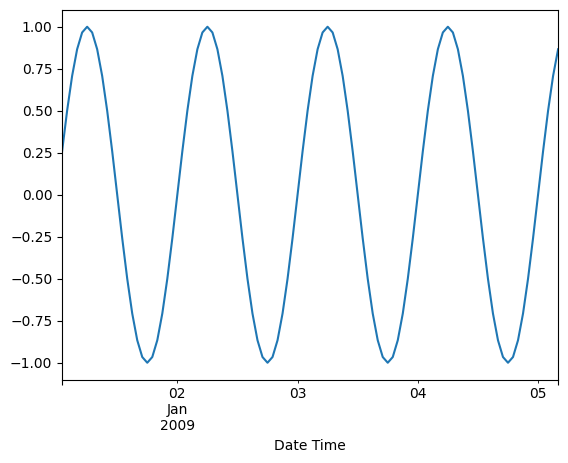

In [183]:
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day sin'][0:100].plot()

<Axes: xlabel='Date Time'>

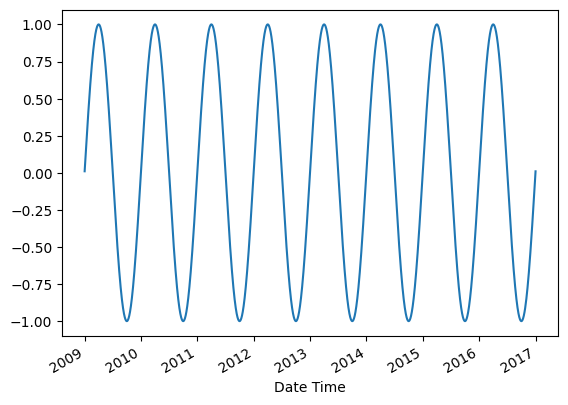

In [184]:
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year sin'].plot() # makes it periodic basically

In [185]:
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temprature,Seconds,Day sin,Year sin,Day cos,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.010049,0.965926,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.010766,0.866025,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.011483,0.707107,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.012199,0.500000,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.012916,0.258819,0.999917


We did not normalise seconds, but we have a monotonically increasing seconds, so it does not work out. It has to wrap around, and be periodic. However, the seconds just increase.

In [186]:
temp_df = temp_df.drop('Seconds', axis = 1) # drop the seconds. 

Change the function we defined abve. Instead of just one variable, we add 

In [187]:
# Recall form before, now we have more than one dataframe. The numbers are hours, 
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]


# And now we have more variables 
# [[[t1, Day sin 1, Day cos 1, Year sin 1, ...], [t2, Day sin 2, Day cos 2, Year sin 2, ...], [t3, Day sin 3, Day cos 3, Year sin 3, ...], [t4], [t5]]] [6]
# [[[t2, Day sin 2, Day cos 2, Year sin 2, ...], [t3, Day sin 3, Day cos 3, Year sin 3, ...], [t4], [t5], [t6]]] [7]
# [[[t3, Day sin 3, Day cos 3, Year sin 3, ...], [t4, Day sin 4, Day cos 4, Year sin 4, ...], [t5], [t6], [t7]]] [8]

# THE LABLE DOES NOT CHANGE, WE ARE STILL PREDICTING THE TEMPRATURE!!


In [188]:
def df_to_X_y2(df, window_size=6): # we also change variables to 6 to see a different shape.
  df_as_np = df.to_numpy()
  X = [] # shape of X is the numbe rof training examples by the number of time stamps we are using by the number of variables we are using 
  y = []
  for i in range(len(df_as_np)-window_size): #iterate through the dataframe with an index
    row = [r for r in df_as_np[i:i+window_size]] # in each iteration we get the next window size of piece of information (each row contains a list of lists of all the varibales we have now)
    X.append(row)
    label = df_as_np[i+window_size][0] # the [0] is the temparture value which is what we ar epredicting. if we want to predict more than one value we modify this index
    y.append(label)
  return np.array(X), np.array(y)

Lets look at the shape of the tensor

In [189]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape # traning example, by windowsize (i.e. the numbe rof time stamps we are windowing)  by 5 variables 

((70085, 6, 5), (70085,))

Let us train the model. Again train, test and validation set.

In [190]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

# Standardisation


We need to be preprocessing for this type of data.
You will notice that the temprature is on a different scale compared ot the rest of the coloumns (sin day, cos day, sin year cos year etc.) So we need to bring it to scale witht he rest of the values (-1,1)

In [191]:
temp_training_mean = np.mean(X2_train[:, :, 0]) #get the mean for temprature for training set [:,:,0] so we get all training set rows, and all five of the steps, and the temap value (index 0) for all of them
temp_training_std = np.std(X2_train[:, :, 0]) #get the std of temprature for training set, indexing as above
                           
def preprocess(X): #standardisation(X-mean(X)/std(X))
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [192]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.04009706e+00, -9.65925826e-01,  5.22877889e-01,
          2.58819045e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.22266764e-01,
          5.00000000e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  5.21655371e-01,
          7.07106781e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  5.21043709e-01,
          8.66025404e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  5.20431780e-01,
          9.65925826e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  5.19819584e-01,
          1.00000000e+00, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.22266764e-01,
          5.00000000e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  5.21655371e-01,
          7.07106781e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  5.21043709e-01,
          8.66025404e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  5.20431780e-01,
  

Now time to Train the model again. It is going to be LSTM model, but the input layer has now changed. 

In [193]:
model4 = Sequential()
model4.add(InputLayer((6, 5))) # we now have 6 timesteps and 5 variables we are using for this 
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                17920     
                                                                 
 dense_24 (Dense)            (None, 8)                 520       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [194]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [195]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
1870/1875 [============================>.] - ETA: 0s - loss: 51.7884 - root_mean_squared_error: 7.1964

1875/1875 [==============================] - 20s 9ms/step - loss: 51.6894 - root_mean_squared_error: 7.1895 - val_loss: 4.8827 - val_root_mean_squared_error: 2.2097
Epoch 2/10
1867/1875 [============================>.] - ETA: 0s - loss: 6.0116 - root_mean_squared_error: 2.4519

1875/1875 [==============================] - 16s 9ms/step - loss: 5.9991 - root_mean_squared_error: 2.4493 - val_loss: 1.7547 - val_root_mean_squared_error: 1.3247
Epoch 3/10
1872/1875 [============================>.] - ETA: 0s - loss: 2.0563 - root_mean_squared_error: 1.4340

1875/1875 [==============================] - 15s 8ms/step - loss: 2.0555 - root_mean_squared_error: 1.4337 - val_loss: 1.0568 - val_root_mean_squared_error: 1.0280
Epoch 4/10
1869/1875 [============================>.] - ETA: 0s - loss: 1.3071 - root_mean_squared_error: 1.1433

1875/1875 [==============================] - 15s 8ms/step - loss: 1.3071 - root_mean_squared_error: 1.1433 - val_loss: 0.8008 - val_root_mean_squared_error: 0.8949
Epoch 5/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.9815 - root_mean_squared_error: 0.9907

1875/1875 [==============================] - 15s 8ms/step - loss: 0.9812 - root_mean_squared_error: 0.9906 - val_loss: 0.6489 - val_root_mean_squared_error: 0.8055
Epoch 6/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.7744 - root_mean_squared_error: 0.8800

1875/1875 [==============================] - 17s 9ms/step - loss: 0.7741 - root_mean_squared_error: 0.8798 - val_loss: 0.5364 - val_root_mean_squared_error: 0.7324
Epoch 7/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.6391 - root_mean_squared_error: 0.7994

1875/1875 [==============================] - 17s 9ms/step - loss: 0.6387 - root_mean_squared_error: 0.7992 - val_loss: 0.4553 - val_root_mean_squared_error: 0.6748
Epoch 8/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.5780 - root_mean_squared_error: 0.7603

1875/1875 [==============================] - 17s 9ms/step - loss: 0.5777 - root_mean_squared_error: 0.7600 - val_loss: 0.4303 - val_root_mean_squared_error: 0.6560
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5491 - root_mean_squared_error: 0.7410 - val_loss: 0.4516 - val_root_mean_squared_error: 0.6720
Epoch 10/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.5388 - root_mean_squared_error: 0.7340

1875/1875 [==============================] - 16s 8ms/step - loss: 0.5385 - root_mean_squared_error: 0.7338 - val_loss: 0.4288 - val_root_mean_squared_error: 0.6548


We have acheived a better result, with not much increase in complexity. lets plot some values

In [ ]:
plot_predictions1(model4, X2_test, y2_test)

# Adding the Pressure (both as input and output)

In [ ]:
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis=1) #pressure and temprature df together
p_temp_df.head()

In [ ]:
def df_to_X_y3(df, window_size=7): #changing the window size to amke it different form the columns
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]] #note that we now have two labels
    y.append(label)
  return np.array(X), np.array(y)

See the shapes and check as expected.


In [ ]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape #training examples, by the length of window (7), by the number of features we are using

In [ ]:
X3_train, y3_train = X3[:60000], y3[:60000]
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

#Standardize again Probably should have been a function

In [ ]:
p_training_mean3 = np.mean(X3_train[:, :, 0]) # as before for temprature
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1]) #now for pressure
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X): #as before
  X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3 #this one is a 1 now as it is the pressure 

def preprocess_output3(y): # standardising the output
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3 # standardise all the rows and the temp column using the stats extracted above
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3 # standardise all the rows and pressure column by the pressure column stats form above 
  return y

In [ ]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [ ]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

In [ ]:
model5 = Sequential()
model5.add(InputLayer((7, 6))) # we have windo size of 7 and 6 input features
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(2, 'linear')) #note the 2 now as we have 2 outputs

model5.summary()

In [ ]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

New model, pretty much the same

In [206]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5])

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.2845 - root_mean_squared_error: 0.5334

1875/1875 [==============================] - 21s 10ms/step - loss: 0.2845 - root_mean_squared_error: 0.5334 - val_loss: 0.0435 - val_root_mean_squared_error: 0.2085
Epoch 2/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0292 - root_mean_squared_error: 0.1708

1875/1875 [==============================] - 18s 9ms/step - loss: 0.0291 - root_mean_squared_error: 0.1706 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1152

1875/1875 [==============================] - 17s 9ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 4/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0974

1875/1875 [==============================] - 16s 8ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.0877

1875/1875 [==============================] - 16s 8ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767
Epoch 6/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0811

1875/1875 [==============================] - 17s 9ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0763

1875/1875 [==============================] - 18s 10ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 8/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 9/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0719

1875/1875 [==============================] - 18s 9ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 10/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0709

1875/1875 [==============================] - 17s 9ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609


In [222]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])



  plt.xlabel('Hours')
  plt.ylabel('Tempratuce (degC)/ or Pressure Bar -- Standardised')
  plt.legend(['Temp Predictions','Temp Actuals','Pressure Predictions','Pressure Actuals'],fontsize="6")


  return df[start:end]

159/159 [==============================] - 0s 3ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.430570,0.412451,-0.797191,-0.793439
1,0.390215,0.353683,-0.785546,-0.763123
2,0.349104,0.323123,-0.751464,-0.721893
3,0.350197,0.250251,-0.698009,-0.652773
4,0.296186,0.254952,-0.610654,-0.652773
...,...,...,...,...
95,0.706753,0.716869,-0.413194,-0.416310
96,0.671886,0.687485,-0.417215,-0.399333
97,0.659440,0.663978,-0.402783,-0.399333
98,0.667935,0.641646,-0.391061,-0.400546


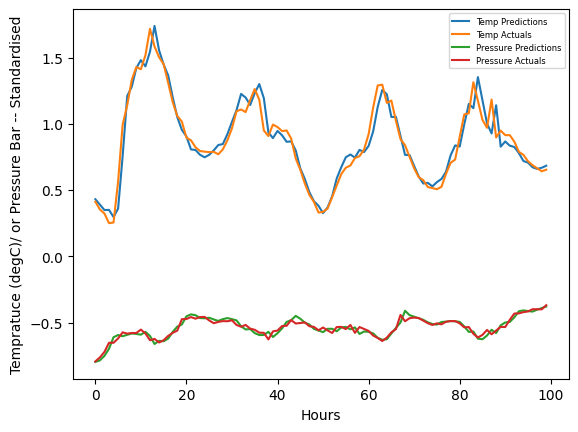

In [223]:
plot_predictions2(model5, X3_test, y3_test)

In [256]:
# Wantto do it with subplots

def plot_predictions3(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  

  fig, ax = plt.subplots( 2,  1, figsize=(15,7))
  #fig.tight_layout()


  ax[0].plot(df['Temperature Predictions'][start:end], label = 'Temp Predictions', color = 'g')
  ax[0].plot(df['Temperature Actuals'][start:end],  label = 'Temp Actuals', color = 'r')
 # ax[0].set_xlabel('Hours')
  ax[0].set_ylabel('Temprature degC')
  ax[0].set_title('Predicted Values Vs. Actials')

  ax[1].plot(df['Pressure Predictions'][start:end], label = 'Pressure Predictions')
  ax[1].plot(df['Pressure Actuals'][start:end], label = 'Pressure Actuals')
  ax[1].set_xlabel('Hours')
  ax[1].set_ylabel('Pressure bar')


  ax[0].legend()
  ax[1].legend(loc = 'lower right')

  plt.show()



  return df[start:end]

159/159 [==============================] - 1s 3ms/step


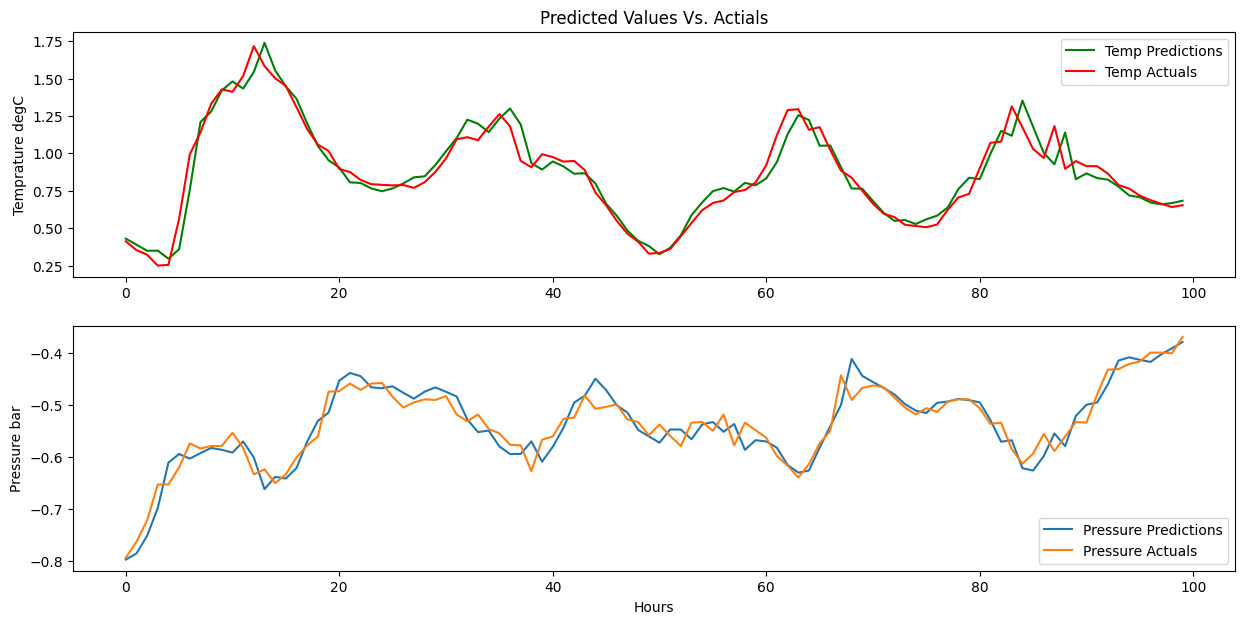

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.430570,0.412451,-0.797191,-0.793439
1,0.390215,0.353683,-0.785546,-0.763123
2,0.349104,0.323123,-0.751464,-0.721893
3,0.350197,0.250251,-0.698009,-0.652773
4,0.296186,0.254952,-0.610654,-0.652773
...,...,...,...,...
95,0.706753,0.716869,-0.413194,-0.416310
96,0.671886,0.687485,-0.417215,-0.399333
97,0.659440,0.663978,-0.402783,-0.399333
98,0.667935,0.641646,-0.391061,-0.400546


In [257]:
plot_predictions3(model5, X3_test, y3_test)

To use the model effectively, we need to do post processing which is effectively undoing what we did previously. This is because whwn we want to model to predict something, that output has to be a real tamprature or pressure value as opposed to a value normalised to the mean and standard deviation of all the other values. As a rsult we do post processing.

In [258]:
def postprocess_temp(arr):
  arr = (arr*temp_training_std3) + temp_training_mean3 # effectively an elemen-wise reverse of what we did
  return arr

def postprocess_p(arr):
  arr = (arr*p_training_std3) + p_training_mean3 #exact same thing as aove for pressure. 
  return arr

In [261]:

def plot_predictions4(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1]) #modify the function with post processed valus on fr temperature and pressure
  p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  

  fig, ax = plt.subplots( 2,  1, figsize=(15,7))
  #fig.tight_layout()


  ax[0].plot(df['Temperature Predictions'][start:end], label = 'Temp Predictions', color = 'g')
  ax[0].plot(df['Temperature Actuals'][start:end],  label = 'Temp Actuals', color = 'r')
 # ax[0].set_xlabel('Hours')
  ax[0].set_ylabel('Temprature degC')
  ax[0].set_title('Predicted Values Vs. Actials')

  ax[1].plot(df['Pressure Predictions'][start:end], label = 'Pressure Predictions')
  ax[1].plot(df['Pressure Actuals'][start:end], label = 'Pressure Actuals')
  ax[1].set_xlabel('Hours')
  ax[1].set_ylabel('Pressure bar')


  ax[0].legend()
  ax[1].legend(loc = 'lower right')

  plt.show()



  return df[start:end]

159/159 [==============================] - 1s 4ms/step


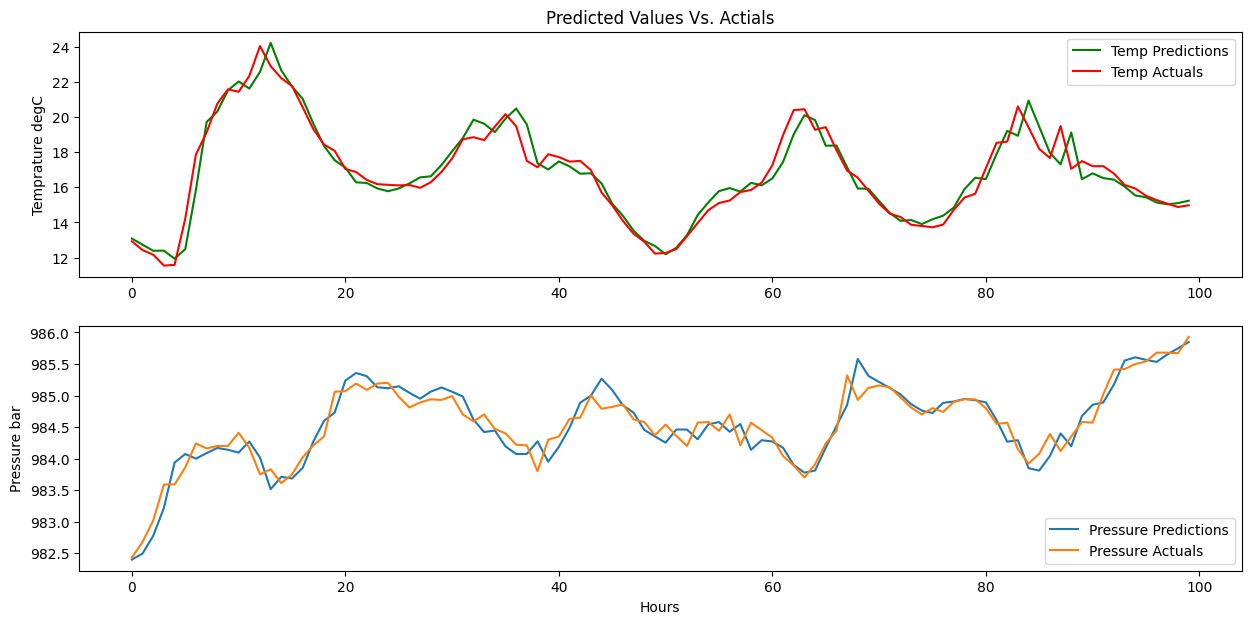

,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,13.084156,12.93,982.399109,982.43
1,12.740822,12.43,982.495117,982.68
2,12.391041,12.17,982.776184,983.02
3,12.400342,11.55,983.216980,983.59
4,11.940814,11.59,983.937378,983.59
...,...,...,...,...
95,15.433928,15.52,985.565735,985.54
96,15.137283,15.27,985.532593,985.68
97,15.031388,15.07,985.651611,985.68
98,15.103662,14.88,985.748230,985.67


In [262]:
post_processed_df = plot_predictions4(model5, X3_test, y3_test)
post_processed_df

If we want to increase complexity, we can add another LSTM layer. The models go heavy and it may overfit but the accuracy would be very high. 

In [263]:
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True)) #LSTM takes a time series, so passes one LSTM into another one too.
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

model6.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 7, 32)             4992      
                                                                 
 lstm_10 (LSTM)              (None, 64)                24832     
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 2)                 18        
                                                                 
Total params: 30,362
Trainable params: 30,362
Non-trainable params: 0
_________________________________________________________________


In [264]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6])

This is a Convolutional NN with different input and output. Sliding across more than 1 variables. So this is a lot lighter and not much sacrifice in terms of accuracy. 

In [265]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

cp7 = ModelCheckpoint('model6/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 6, 64)             832       
                                                                 
 flatten_3 (Flatten)         (None, 384)               0         
                                                                 
 dense_30 (Dense)            (None, 8)                 3080      
                                                                 
 dense_31 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
_________________________________________________________________


In [266]:
model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7])

Epoch 1/10
1861/1875 [============================>.] - ETA: 0s - loss: 0.0891 - root_mean_squared_error: 0.2985

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0886 - root_mean_squared_error: 0.2976 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 2/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1148

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0972
Epoch 3/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0941

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - root_mean_squared_error: 0.0941 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0854

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 5/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0808

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0780

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0701
Epoch 7/10
1858/1875 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0762

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0749

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0672
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 10/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0733

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
